Instructions

We will be trying to predict if a customer will be renting a film this month based on their previous activity and other details. We will first construct a table with:

- Customer ID *
- City *
- Most rented film category
- Total films rented *
- Total money spent *
- How many films rented last month*
- Predict if he will be renting this month. 
- Use date range (15/05/2005 - 30/05/2005) for last month and (15/06/2005 - 30/06/2005) for this month.

# Importing Libraries

In [29]:
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [30]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("whitegrid")

# I. Establishing connection to my SQL

In [31]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/bank'
engine = create_engine(connection_string)

# II. The data

### Getting the tables

a) From this query we get Customer ID, City, Total Films Rented and Total Money Spent

In [32]:
query1 = "select c.customer_id as 'Customer ID', ci.city as 'City', count(p.rental_id) as 'Total Films Rented',sum(p.amount) as 'Total Money Spent' from sakila.customer as c \
left join sakila.address as a \
on c.address_id=a.address_id \
left join sakila.city as ci \
on a.city_id=ci.city_id \
left join sakila.payment as p \
on c.customer_id=p.customer_id \
group by c.customer_id \
order by c.customer_id"

df1 = pd.read_sql_query(query1, engine)
df1.head()

,Customer ID,City,Total Films Rented,Total Money Spent
0,1,Sasebo,32,118.68
1,2,San Bernardino,27,128.73
2,3,Athenai,26,135.74
3,4,Myingyan,22,81.78
4,5,Nantou,38,144.62


b. Most rented Film Category

In [33]:
query2="with cte_ranked_categories as (select r.customer_id, c.name, count(r.rental_id) as rented_movies, row_number() over (partition by customer_id order by count(r.rental_id) desc) as Position from sakila.rental as r \
join sakila.inventory as i \
on r.inventory_id=i.inventory_id \
join sakila.film_category as fc \
on i.film_id=fc.film_id \
join sakila.category as c \
on fc.category_id=c.category_id \
group by customer_id, name \
order by customer_id, count(r.rental_id) desc) \
select*from cte_ranked_categories \
where Position=1"
df2 = pd.read_sql_query(query2, engine)
df2.head()

,customer_id,name,rented_movies,Position
0,1,Classics,6,1
1,2,Sports,5,1
2,3,Action,4,1
3,4,Horror,3,1
4,5,Classics,7,1


In [34]:
df2=df2.drop(["customer_id","rented_movies","Position"], axis=1)

c. Films rented last month

In [35]:
query3 ="select c.customer_id as 'Customer ID', count(r.rental_id) as 'Last month rentals' from sakila.customer as c \
left outer join sakila.rental as r \
on c.customer_id=r.customer_id and (r.rental_date >= '2005-05-15') and (r.rental_date <= '2005-05-30') \
group by c.customer_id \
order by c.customer_id"
df3 = pd.read_sql_query(query3, engine)
print(df3.shape)
df3.head()

(599, 2)


,Customer ID,Last month rentals
0,1,2
1,2,1
2,3,2
3,4,0
4,5,1


In [36]:
df3=df3.drop("Customer ID", axis=1)

d. Films rented this month

In [37]:
query4 ="select c.customer_id as 'Customer ID', count(r.rental_id) as 'This month rentals' from sakila.customer as c \
left outer join sakila.rental as r \
on c.customer_id=r.customer_id and (r.rental_date >= '2005-06-15') and (r.rental_date <= '2005-06-30') \
group by c.customer_id \
order by c.customer_id"
df4 = pd.read_sql_query(query4, engine)
print(df4.shape)
df4.head()

(599, 2)


,Customer ID,This month rentals
0,1,7
1,2,1
2,3,4
3,4,6
4,5,5


In [38]:
df4=df4.drop("Customer ID", axis=1)

### Concatenating the tables

In [39]:
df=pd.concat([df1,df2,df3,df4], axis=1)
print(df.shape)
df.head()

(599, 7)


,Customer ID,City,Total Films Rented,Total Money Spent,name,Last month rentals,This month rentals
0,1,Sasebo,32,118.68,Classics,2,7
1,2,San Bernardino,27,128.73,Sports,1,1
2,3,Athenai,26,135.74,Action,2,4
3,4,Myingyan,22,81.78,Horror,0,6
4,5,Nantou,38,144.62,Classics,1,5


# III. Data Cleaning

#### 1. Changing the headers

In [40]:
df.columns

Index(['Customer ID', 'City', 'Total Films Rented', 'Total Money Spent',
       'name', 'Last month rentals', 'This month rentals'],
      dtype='object')

In [41]:
df.columns= (['Customer ID', 'City', 'Total Films Rented', 'Total Money Spent',
       'Category', 'Rented Last Month',
       'Rented This Month'])
df.head()

,Customer ID,City,Total Films Rented,Total Money Spent,Category,Rented Last Month,Rented This Month
0,1,Sasebo,32,118.68,Classics,2,7
1,2,San Bernardino,27,128.73,Sports,1,1
2,3,Athenai,26,135.74,Action,2,4
3,4,Myingyan,22,81.78,Horror,0,6
4,5,Nantou,38,144.62,Classics,1,5


#### 2. Checking the data type

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer ID         599 non-null    int64  
 1   City                599 non-null    object 
 2   Total Films Rented  599 non-null    int64  
 3   Total Money Spent   599 non-null    float64
 4   Category            599 non-null    object 
 5   Rented Last Month   599 non-null    int64  
 6   Rented This Month   599 non-null    int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 32.9+ KB


In [43]:
#We will drop the column "Customer ID" because it is not useful for the exercise, we do not need it!
df=df.drop("Customer ID", axis=1)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   City                599 non-null    object 
 1   Total Films Rented  599 non-null    int64  
 2   Total Money Spent   599 non-null    float64
 3   Category            599 non-null    object 
 4   Rented Last Month   599 non-null    int64  
 5   Rented This Month   599 non-null    int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 28.2+ KB


In [46]:
#As we will be attempting a logistic regression model I will be transforming the data of the columns y which will be rented this and last month so that it becomes binary.

for i in range(len(df)):
    if df.loc[i, "Rented Last Month"]>0:
        df.loc[i, "Rented Last Month"]='Yes'
    else:
        df.loc[i, "Rented Last Month"]='No'

In [47]:
for i in range(len(df)):
    if df.loc[i, "Rented This Month"]>0:
        df.loc[i, "Rented This Month"]='Yes'
    else:
        df.loc[i, "Rented This Month"]='No'

In [48]:
df.head()

,City,Total Films Rented,Total Money Spent,Category,Rented Last Month,Rented This Month
0,Sasebo,32,118.68,Classics,Yes,Yes
1,San Bernardino,27,128.73,Sports,Yes,Yes
2,Athenai,26,135.74,Action,Yes,Yes
3,Myingyan,22,81.78,Horror,No,Yes
4,Nantou,38,144.62,Classics,Yes,Yes


#### 3. Drop duplicates

In [49]:
df.drop_duplicates()

,City,Total Films Rented,Total Money Spent,Category,Rented Last Month,Rented This Month
0,Sasebo,32,118.68,Classics,Yes,Yes
1,San Bernardino,27,128.73,Sports,Yes,Yes
2,Athenai,26,135.74,Action,Yes,Yes
3,Myingyan,22,81.78,Horror,No,Yes
4,Nantou,38,144.62,Classics,Yes,Yes
...,...,...,...,...,...,...
594,Jinzhou,30,117.70,Documentary,Yes,Yes
595,Patras,28,96.72,Sports,Yes,Yes
596,Sullana,25,99.75,Foreign,Yes,Yes
597,Lausanne,22,83.78,Drama,No,Yes


=> There were no duplicates

# IV. Data Processing

### I. X-Y Split

In [90]:
y=df["Rented This Month"]
x=df.drop(["Rented This Month"], axis=1)

In [91]:
x.head()

,City,Total Films Rented,Total Money Spent,Category,Rented Last Month
0,Sasebo,32,118.68,Classics,Yes
1,San Bernardino,27,128.73,Sports,Yes
2,Athenai,26,135.74,Action,Yes
3,Myingyan,22,81.78,Horror,No
4,Nantou,38,144.62,Classics,Yes


### II. Numerical Data

In [92]:
#Getting the numerical data 
x_num=df.select_dtypes("number")
x_num.head()

,Total Films Rented,Total Money Spent
0,32,118.68
1,27,128.73
2,26,135.74
3,22,81.78
4,38,144.62


Distplot:  Total Films Rented


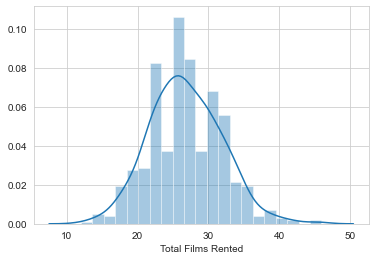

Distplot:  Total Money Spent


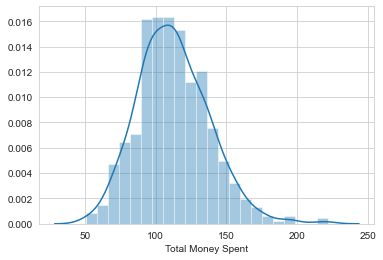

In [93]:
#Normalisation check
cols = list(x_num)
for col in cols:
    print("Distplot: ",col)
    sns.distplot(x_num[col])
    plt.show()

In [94]:
#Normalisation
from sklearn.preprocessing import Normalizer

scaler=Normalizer().fit(x_num)
x_normalised=scaler.transform(x_num)
x_num_norm=pd.DataFrame(x_normalised)
x_num_norm.head()

,0,1
0,0.260335,0.965518
1,0.205275,0.978704
2,0.188123,0.982146
3,0.259779,0.965668
4,0.254131,0.967170


In [95]:
x_num_norm.columns=x_num.columns
x_num_norm.head()

,Total Films Rented,Total Money Spent
0,0.260335,0.965518
1,0.205275,0.978704
2,0.188123,0.982146
3,0.259779,0.965668
4,0.254131,0.967170


Distplot:  Total Films Rented


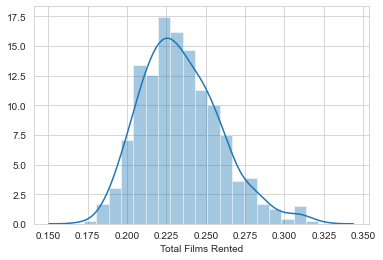

Distplot:  Total Money Spent


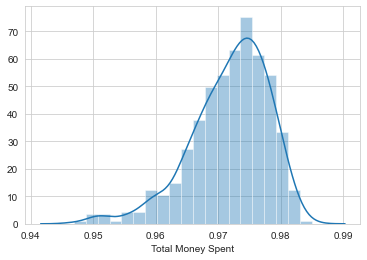

In [96]:
#Plot after normalisation
cols = list(x_num_norm)
for col in cols:
    print("Distplot: ",col)
    sns.distplot(x_num_norm[col])
    plt.show()

We can see the distribution has improved

### III. Categorical Data

In [97]:
#Getting the categorical data
x_cat=x.select_dtypes("object")
x_cat.head()

,City,Category,Rented Last Month
0,Sasebo,Classics,Yes
1,San Bernardino,Sports,Yes
2,Athenai,Action,Yes
3,Myingyan,Horror,No
4,Nantou,Classics,Yes


In [98]:
#Dummies
x_cat_dummies=pd.get_dummies(x_cat, drop_first=False, dtype=None)
x_cat_dummies.head()

,City_A Corua (La Corua),City_Abha,City_Abu Dhabi,City_Acua,City_Adana,City_Addis Abeba,City_Aden,City_Adoni,City_Ahmadnagar,City_Akishima,...,Category_Foreign,Category_Games,Category_Horror,Category_Music,Category_New,Category_Sci-Fi,Category_Sports,Category_Travel,Rented Last Month_No,Rented Last Month_Yes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [99]:
### IV. Concatenate x data
x_processed=pd.concat([x_cat_dummies,x_num_norm],axis=1)
x_processed.head()

,City_A Corua (La Corua),City_Abha,City_Abu Dhabi,City_Acua,City_Adana,City_Addis Abeba,City_Aden,City_Adoni,City_Ahmadnagar,City_Akishima,...,Category_Horror,Category_Music,Category_New,Category_Sci-Fi,Category_Sports,Category_Travel,Rented Last Month_No,Rented Last Month_Yes,Total Films Rented,Total Money Spent
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0.260335,0.965518
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0.205275,0.978704
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0.188123,0.982146
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0.259779,0.965668
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0.254131,0.967170


# V. The Model

In [100]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_processed, y, test_size=0.2, random_state=250)

In [101]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='ovr').fit(x_train, y_train)

In [103]:
from sklearn.metrics import accuracy_score
predictions = classification.predict(x_test)

The accuracy of the model on test set is: 0.97 


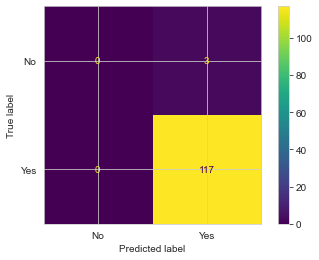

Cohen Kappa score 0.0


In [104]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
print("The accuracy of the model on test set is: %4.2f " % accuracy_score(y_test, predictions))
confusion_matrix(y_test, predictions)
plot_confusion_matrix(classification, x_test, y_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP

from sklearn.metrics import cohen_kappa_score
print('Cohen Kappa score',cohen_kappa_score(y_test, predictions))

**Conclusion: WE DO NOT HAVE ENOUGH NO´S IN OUR DATA SET THAT IS WHY THE YES IS SO WELL PREDICTED AND THE NO IS NOT**

**In order to improve our model we should consider other normalisation methods, increase our data set to increase the number of "No" values, removing variables so decrease multicolinearity, leaving the "Rented Last Month" with the number and without transforming it...**